# Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals
<br />

### Fredy Vides 
### Scientific Computing Innovation Center, Universidad Nacional Autónoma de Honduras

This notebook notebook is related to the document [1], and contains programs for the computation of discrete-time signal models of the form:
$$
x_{t+1}=\mathcal{L}(x_{t},\ldots,x_{t-L+1})+\mathcal{G}(x_{t},\ldots,x_{t-L+1})+\mathcal{E}(x_{t},\ldots,x_{t-L+1}), t\geq L
$$
for some given approximately eventually periodic signal $\Sigma=\{x_t\}_{t\geq 1}$. The terms $\mathcal{L}$, $\mathcal{G}$ and $\mathcal{E}$, denote the linear, nonlinear and error terms of the model, respectively.


## Install and Include programs and modules

In [1]:
# For execution on IBM Quantum Lab
#!pip install tensorflow-cpu
#!pip install -U numpy
#!pip install -U torch
#!pip install -U torchvision

# For execution on Google Colab
#!pip install -U statsmodels

from pandas import read_csv
from matplotlib.pyplot import plot,stem,show,subplots,legend,semilogy
from numpy import append,array,ceil,fliplr,roots,reshape,zeros,real,imag,linspace,cos,sin,pi,inf,where,identity,ceil,count_nonzero
from numpy.linalg import norm,eig,svd
from statsmodels.tsa.ar_model import AutoReg

## Define sparse linear least squares solver

In [2]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
LSSPSOLVER  Sparse linear least squares solver
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""

def lsspsolver(A,Y,L=100,tol=1e-2,delta=1e-2):
    from numpy.linalg import svd,lstsq,norm
    from numpy import zeros,dot,diag,argsort,sort,inf
    N=A.shape[1]
    X=zeros((N,))
    u,s,v=svd(A,full_matrices=0)
    rk=sum(s>tol)
    u=u[:,:rk]
    s=s[:rk]
    s=1/s
    s=diag(s)
    v=v[:rk,:]
    A=dot(u.T,A)
    Y=dot(u.T,Y)
    X0=dot(v.T,dot(s,Y))
    w=zeros((N,))
    K=1
    Error=1+tol
    c=X0
    x0=c
    ac=abs(c)
    f=argsort(-ac)
    N0=max(sum(ac[f]>delta),1)
    while (K<=L) & (Error>tol):
        ff=f[:N0]
        X=w
        c, res, rnk, s = lstsq(A[:,ff],Y,rcond=None)
        X[ff]=c
        Error=norm(x0-X[:],inf)
        x0=X
        ac=abs(x0)
        f=argsort(-ac)
        N0=max(sum(ac[f]>delta),1)
        K=K+1
    return X

## Define Lag Estimator

In [3]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
LAGESTIMATE ACF-FFT based sparse lag estimator
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""
def LagEstimate(data,L0):
    from statsmodels.tsa.stattools import acf 
    from scipy.signal import find_peaks
    from numpy import where
    L = acf(data,adjusted=False,nlags=len(data),fft=True)
    p = find_peaks(L)
    q=where(L[p[0]]==L[p[0]].max())
    L = max(p[0][q[0][0]],L0)
    return L

## Define Sparse Autoregressor

In [4]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
SPAUTOREGRESSOR  Sparse autoregressor for time series modeling
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""
def SpAutoRegressor(x,ssp,sp,pp,L0,tol,delta):
    from numpy import ceil,floor,max,min,asmatrix
    from scipy.linalg import hankel
    sl = len(x)
    ssp=int(ceil(sl*ssp))
    x = x[0:sl:ssp]
    sl = len(x)
    sp = int(ceil(sp*sl))
    xt = x[:sp]
    pp = max([min([floor(pp*sp),sl-sp]),L0])
    xl = x[(sp+1):]
    L=L0
    H=hankel(xt[:L],xt[(L-1):])
    Lh=H.shape[1]
    H0=H[:,:-1]
    H1=H[L-1,1:]
    A = lsspsolver(H0.T,H1.T,L,tol,delta)
    return A.T,H0[:,0]   

## Define Sparse Predictor

In [5]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
SPARPREDICTOR  Sparse AR predictor for time series modeling
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""

def SPARPredictor(A,h,N):
    from numpy import append
    y=h
    L = len(h)
    for k in range(N):
        y = append(y,A.dot(h))
        h = y[k+1:L+k+1]
    return y

## Define GRU RNN Models

## Using TensorFlow

In [6]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
SPGRUMODEL GRU based sparse signal model
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""
def SpGRUModel(data,Lag,sp,nn,ep,spp = 0.1):
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import GRU
    from keras import regularizers
    from sklearn.metrics import mean_squared_error
    from numpy import append,reshape,vstack,arange
    from scipy.linalg import hankel
    from keras.callbacks import EarlyStopping
    
    md = data.min()
    
    Md = abs(data - md).max()
    
    data = (data-md)/Md
    
    L = int(len(data) * sp)
    
    xt = data[:L]
    
    H = hankel(xt[:Lag],xt[(Lag-1):]).T
    
    Xt = H[:-1,:]
    Yt = H[1:,Lag-1]
    
    Xt = reshape(Xt, (Xt.shape[0], 1, Xt.shape[1]))
    
    TS_Model = Sequential([
        GRU(nn, input_shape=(1, Lag),
                  kernel_regularizer=regularizers.l1(spp),
                  bias_regularizer=regularizers.l1(spp),
                  activity_regularizer=regularizers.l1(spp)),
        Dense(1,kernel_regularizer=regularizers.l1(spp),
                  bias_regularizer=regularizers.l1(spp),
                  activity_regularizer=regularizers.l1(spp))
        ])
        
    TS_Model.compile(loss='mean_squared_error', optimizer='adam')
    
    callback = EarlyStopping(monitor='loss', mode='min', 
                         verbose=0, patience=10,min_delta=9e-4)
    
    TS_Model.fit(Xt, Yt, epochs=ep, batch_size=16, verbose=0,
             workers=6,use_multiprocessing=True,callbacks=[callback])
    
    h = data[:Lag].copy()
    
    return TS_Model,H,h

In [7]:
"""
Created on Wed Mar 31 02:57:52 2021
SPGRUPREDICTOR GRU based sparse predictor
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""
def SpGRUPredictor(data,model,h,N):
    from numpy import append,reshape
    Lag = len(h)
    md = data.min()
    Md = abs(data - md).max()
    X = []
    x0 = []
    X = h
    x0 = reshape(h.copy(),(1,1,Lag))
    for j in range(N):
        x = model(x0)
        x0[:1,:,:][0][0][:-1]=x0[:1,:,:][0][0][1:]
        x0[:1,:,:][0][0][-1]=x
        X = append(X,x)
    X = Md*X+md    
    return X

## Using PyTorch

In [8]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
SPGRUMODEL GRU based sparse signal model
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""
def SpGRUModelTorch(data,Lag,sp,N,ep,spp = 0.1):
    import torch
    import torch.nn as nn
    import numpy as np
    from numpy import reshape
    from scipy.linalg import hankel
    
    md = data.min()
    
    Md = abs(data - md).max()
    
    data = (data-md)/Md
    
    L = int(len(data) * sp)
    
    xt = data[:L]
    
    H = hankel(xt[:Lag],xt[(Lag-1):]).T
    Xt = H[:-1,:]
    Yt = H[1:,-1]
    
    Xtt = []
    Ytt = []
    for k in range(Xt.shape[0]-1):
        Xtt.append(torch.FloatTensor(reshape(Xt[k],(1,1,Lag))))
        Ytt.append(torch.FloatTensor(reshape(Yt[k],(1,1,1))))
    
    class GRU_Adapter(nn.Module):
        def __init__(self, index):
            super(GRU_Adapter, self).__init__()
            self._name = 'gru_adapter'
            self.index = index
        def forward(self, inputs):
            return inputs[self.index]
   
    model = torch.nn.Sequential(
        torch.nn.GRU(Lag,N,batch_first=True),
        GRU_Adapter(1),
        torch.nn.Linear(N,1)
        )
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=spp)
    
    error = 1.0
    i = 0
    while i <= ep and error>10*spp:
        for k in range(len(Ytt)):
            optimizer.zero_grad()
            y_pred = model(Xtt[k])
            single_loss = loss_function(y_pred, Ytt[k])
            single_loss.backward()
            optimizer.step()
        error = single_loss.item()
    
    h = data[:Lag]
    
    return model,H,h

In [9]:
"""
Created on Wed Mar 31 02:57:52 2021
SPGRUPREDICTOR GRU based sparse predictor
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""
def SpGRUPredictorTorch(data,model,h,N):
    from numpy import append,reshape
    from torch import FloatTensor
    Lag = len(h)
    md = data.min()
    Md = abs(data - md).max()
    X = []
    x0 = []
    X = h
    x0 = FloatTensor(reshape(h.copy(),(1,1,Lag)))
    for j in range(N):
        x = model(x0)
        xc = x0.clone()
        x0[0][0][:-1] = xc[0][0][1:]
        x0[0][0][-1]=x.detach()
        X = append(X,x.detach().numpy()[0][0])
    X = Md*X+md
    return X

## Set experiment number and some model parameters

In [12]:
experiment_number = 2
delta = 1e-1
tol = 1e-1
if experiment_number <= 1:
    url = "https://raw.githubusercontent.com/FredyVides/SPAAR/main/DataSets/AlmostPeriodicSignal.csv"
    tol = 4e-2
    data = read_csv(url)
    data = data.values[0,:]
elif experiment_number == 2:
    url = "https://raw.githubusercontent.com/FredyVides/SPAAR/main/DataSets/NLOscillatorSignal.csv"
    tol = 5e-3
    data = read_csv(url)
    data = data.values[1,:]
elif experiment_number == 3:
    url = "https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_no_noise.csv"
    data = read_csv(url, usecols=[1])
    data = data.values[:,0]
elif experiment_number >= 4:
    url = "https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv"
    data = read_csv(url, usecols=[1])
    data = data.values[:,0]

sampling_proportion = 0.5
Lag = LagEstimate(data,10)
nn = 16
ep = 60
md = data.min()
Md = abs(data - md).max()
steps = len(data)-Lag
spp = 1e-5

x = data
mx = x.min()
Mx = abs(x-mx).max()
xs = 2*(x-mx)/Mx-1

L0 = int(ceil(sampling_proportion*len(xs)))

## Compute Models

In [13]:
# Using standard autoregressor

ss=1
Xs = xs.copy()
Xs = Xs[:len(Xs):ss]
train, test = Xs[:L0], Xs[L0:]
model = AutoReg(train, lags=Lag, old_names=False)
model_fit = model.fit()
B = model_fit.params[1:]

# Using sparse autoregressor

A,h_0 = SpAutoRegressor(xs,1/len(xs),sampling_proportion,1,Lag,delta,tol)

# Using TensorFlow GRU RNN

TS_Model,H,h = SpGRUModel(data.copy(),Lag,sampling_proportion,nn,ep,spp)

# Using PyTorch RNN

TS_Model_1,H_1,h_1 = SpGRUModelTorch(data.copy(),Lag,sampling_proportion,nn,ep,spp)

## Compute sparse refinement of the input weights for the TensorFlow GRU models

In [14]:
W = TS_Model.layers[0].get_weights()

X01 = H@W[0]
U = [] 
for k in range(W[0].shape[1]):
    w1 = lsspsolver(H,X01[:,k],100,delta,5e-3)
    U.append(w1)

U=array(U)

W[0] = U.T
    
TS_Model.layers[0].set_weights(W)

## Compute predictions

In [15]:
 # With the sparse autoregressor
y = Mx*(SPARPredictor(A,h_0,steps)+1)/2+mx
# With the standard autoregressor
predictions = model_fit.predict(Lag, end=len(data)-1, dynamic=False)
predictions = Mx*(predictions+1)/2+mx
predictions = append(data[:Lag],predictions)
# With the TensorFlow GRU model
X = SpGRUPredictor(data.copy(),TS_Model,h.copy(),steps)
# With the PyTorch GRU model
X1 = SpGRUPredictorTorch(data.copy(),TS_Model_1,h_1.copy(),steps)

## Extract approximately periodic component from the approximate spectra

In [16]:
threshold = delta

C0 = zeros((Lag,Lag))
for k in range(Lag-1):
    C0[k,k+1]=1

C1 = C0.copy()
C0[-1,:] = A
C1[-1,:] = B

t = linspace(0,1,1001)
xt = cos(2*pi*t)
yt = sin(2*pi*t)

h01 = data[:Lag].copy()
h02 = h01.copy()

h1 = []
h2 = []
for k in range(Lag):
    h1.append(h01)
    h2.append(h02)
    h01 = C0@h01
    h02 = C1@h02

h01 = array(h1).T
h02 = array(h2).T

u1,s1,_ = svd(h01,full_matrices=False)
u2,s2,_ = svd(h02,full_matrices=False)

r1 = sum(s1>threshold)
r2 = sum(s2>threshold)

u1 = u1[:,:r1]
u2 = u2[:,:r2]

C00 = u1.conj().T@C0@u1
C01 = u2.conj().T@C1@u2
D00 = C00
D01 = C01

l0,_ = eig(C00)
l1,_ = eig(C01)

for k in range(Lag-1):
    D00 = D00@C00
    D01 = D01@C01
    
l00,_ = eig(D00)
l01,_ = eig(D01)

## Compute mixed model and plot the results summary

[ 1.00337193  0.01453117 -0.01932607]


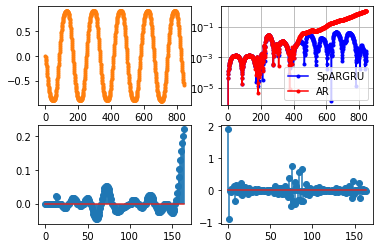

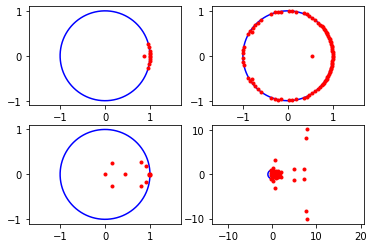

In [17]:
A0 = zeros((3,L0))
A0[0,:] = y[:L0]
A0[1,:] = X[:L0]
A0[2,:] = X1[:L0]
W0 = lsspsolver(A0.T,data[:L0],100,1e-2,1e-2)
print(W0)

z = W0[0]*y+W0[1]*X+W0[2]*X1

fig_0,axs_0 = subplots(2,2)
axs_0[0,0].plot(data),axs_0[0,0].plot(z,'.-')
axs_0[0,1].semilogy(abs(data-z),'b.-')
axs_0[0,1].semilogy(abs(predictions-z),'r.-')
axs_0[0,1].grid(True)
axs_0[0,1].legend(['SpARGRU','AR'])
axs_0[1,0].stem(A)
axs_0[1,1].stem(B)
fig_1,axs_1 = subplots(2,2)
axs_1[0,0].plot(xt,yt,'b')
axs_1[0,0].plot(real(l0),imag(l0),'r.')
axs_1[0,0].axis('equal')
axs_1[0,1].plot(xt,yt,'b')
axs_1[0,1].plot(real(l1),imag(l1),'r.')
axs_1[0,1].axis('equal')
axs_1[1,0].plot(xt,yt,'b')
axs_1[1,0].plot(real(l00),imag(l00),'r.')
axs_1[1,0].axis('equal')
axs_1[1,1].plot(xt,yt,'b')
axs_1[1,1].plot(real(l01),imag(l01),'r.')
axs_1[1,1].axis('equal')
show()

## References

1. Vides, F. (2021). Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals. Technical report. URL https://github.com/FredyVides/SPAAR/blob/main/Documentation/SLSpAAR_FVides.pdf.